In [2]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')

from six.moves import cPickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

import kde
import simplebinmi

import utils
trn, tst = utils.get_mnist()

# Which measure to plot
infoplane_measure = 'upper'
#infoplane_measure = 'bin'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = True    # (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = True    #(infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 100     # Max number of epoch for which to compute mutual information measure
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 100

# Directories from which to load saved layer activity
ARCH = '1024-20-20-20'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
#ARCH = '32-28-24-20-16-12-8-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-1                    # Added Gaussian noise variance
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])


# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 


# Save indexes of tests data for each of the output classes
saved_labelixs = {}
for i in range(10):
    saved_labelixs[i] = tst.y == i

labelprobs = np.mean(tst.Y, axis=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['relu'] = {}
measures['tanh'] = {}

Compute MI measures
-----

In [4]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(10):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(10):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                    
                    
            # # It's also possible to treat the last layer probabilistically. Here is the 
            # # code to do so. Should only be applied when lndx == num_layers - 1

            # ps = activity.mean(axis=0)
            # h_lower = h_upper = sum([-p*np.log(p) for p in ps if p != 0])

            # x = -activity * np.log(activity)
            # x[activity == 0] = 0.
            # hM_given_X = np.mean(x.sum(axis=1))

            # hM_given_Y=0.
            # for i in range(10):
            #     ixs = tst.y[::subsample] == i
            #     ps = activity[ixs,:].mean(axis=0)
            #     hcond = sum([-p*np.log(p) for p in ps if p != 0])
            #     prob = np.mean(ixs)
            #     hM_given_Y += l * hcond
            # hM_given_Y_lower = hM_given_Y_upper = hM_given_Y
            # del hM_given_Y
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binner estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
            
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata
    

Directory rawdata/relu_1024-20-20-20 not found
*** Doing rawdata/tanh_1024-20-20-20 ***
Doing rawdata/tanh_1024-20-20-20/epoch00000000
- Layer 0 upper: MI(X;M)=13.288, MI(Y;M)=3.319 | lower: MI(X;M)=13.281, MI(Y;M)=3.319 | bin: MI(X;M)=13.288, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=11.694, MI(Y;M)=3.086 | lower: MI(X;M)=5.741, MI(Y;M)=1.823 | bin: MI(X;M)=13.215, MI(Y;M)=3.317
- Layer 2 upper: MI(X;M)=10.509, MI(Y;M)=2.796 | lower: MI(X;M)=5.205, MI(Y;M)=1.764 | bin: MI(X;M)=13.110, MI(Y;M)=3.303
- Layer 3 upper: MI(X;M)=8.954, MI(Y;M)=2.431 | lower: MI(X;M)=4.554, MI(Y;M)=1.691 | bin: MI(X;M)=12.764, MI(Y;M)=3.219
- Layer 4 upper: MI(X;M)=0.535, MI(Y;M)=0.359 | lower: MI(X;M)=0.143, MI(Y;M)=0.097 | bin: MI(X;M)=-0.000, MI(Y;M)=-0.000
Doing rawdata/tanh_1024-20-20-20/epoch00000001
- Layer 0 upper: MI(X;M)=13.288, MI(Y;M)=3.319 | lower: MI(X;M)=13.281, MI(Y;M)=3.319 | bin: MI(X;M)=13.288, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=11.894, MI(Y;M)=3.196 | lower: MI(X;M)=6.451, MI(Y;M)=2.212 

Plot overall summaries
----

This is more for diagnostic purposes, not for article


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')


#PLOT_LAYERS = [0,1,2,3,4] # [1,2,3]
#PLOT_LAYERS = [0,1,2,3]
#PLOT_LAYERS = [0,1,2,3]
plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4,2)
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
        
    plt.subplot(gs[0,actndx])
    for lndx, layerid in enumerate(PLOT_LAYERS):
        xmvalsU = np.array([vals[epoch]['H_M_upper'][layerid] for epoch in epochs])
        if DO_LOWER:
            xmvalsL = np.array([vals[epoch]['H_M_lower'][layerid] for epoch in epochs])
        plt.plot(epochs, xmvalsU, label='Layer %d'%layerid)
        #plt.errorbar(epochs, (xmvalsL + xmvalsU)/2,xmvalsU - xmvalsL, label='Layer %d'%layerid)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(activation)
    plt.ylabel('H(M)')
    
    plt.subplot(gs[1,actndx])
    for lndx, layerid in enumerate(PLOT_LAYERS):
        #for epoch in epochs:
        #    print('her',epoch, measures[activation][epoch]['MI_XM_upper'])
        xmvalsU = np.array([vals[epoch]['MI_XM_upper'][layerid] for epoch in epochs])
        if DO_LOWER:
            xmvalsL = np.array([vals[epoch]['MI_XM_lower'][layerid] for epoch in epochs])
        plt.plot(epochs, xmvalsU, label='Layer %d'%layerid)
        #plt.errorbar(epochs, (xmvalsL + xmvalsU)/2,xmvalsU - xmvalsL, label='Layer %d'%layerid)
    plt.xscale('log')
    plt.ylabel('I(X;M)')


    plt.subplot(gs[2,actndx])
    for lndx, layerid in enumerate(PLOT_LAYERS):
        ymvalsU = np.array([vals[epoch]['MI_YM_upper'][layerid] for epoch in epochs])
        if DO_LOWER:
            ymvalsL = np.array([vals[epoch]['MI_YM_lower'][layerid] for epoch in epochs])
        plt.plot(epochs, ymvalsU, label='Layer %d'%layerid)
    plt.xscale('log')
    plt.ylabel('MI(Y;M)')

    if DO_BINNED:
        plt.subplot(gs[3,actndx])
        for lndx, layerid in enumerate(PLOT_LAYERS):
            hbinnedvals = np.array([vals[epoch]['MI_XM_bin'][layerid] for epoch in epochs])
            plt.semilogx(epochs, hbinnedvals, label='Layer %d'%layerid)
        plt.xlabel('Epoch')
        plt.ylabel("I(X;M)bin")
    
    if actndx == 0:
        plt.legend(loc='lower right')
        
plt.tight_layout()

ModuleNotFoundError: No module named 'seaborn'

Plot Infoplane Visualization
----

C:\Users\Omar\AppData\Local\Temp\ipykernel_17768\684448324.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


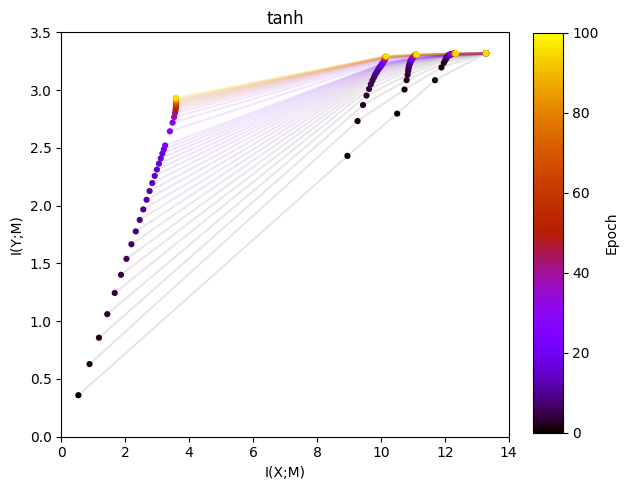

In [6]:
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)
    
    plt.ylim([0, 3.5])
    plt.xlim([0, 14])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.title(activation)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')
    
    
    

Plot SNR curves
----

TypeError: LogScale.__init__() got an unexpected keyword argument 'nonposx'

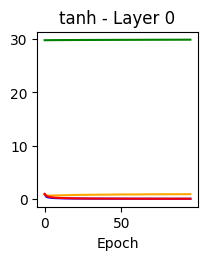

In [7]:
plt.figure(figsize=(12,5))

gs = gridspec.GridSpec(len(measures), len(PLOT_LAYERS))
saved_data = {}
for actndx, activation in enumerate(measures.keys()):
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        continue
        
    epochs = []
    means = []
    stds = []
    wnorms = []
    trnloss = []
    tstloss = []
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        with open(cur_dir + "/"+epochfile, 'rb') as f:
            try:
                d = cPickle.load(f)
            except:
                print('Error loading ', epochfile)
                continue
            
        epoch = d['epoch']
        epochs.append(epoch)
        wnorms.append(d['data']['weights_norm'])
        means.append(d['data']['gradmean'])
        stds.append(d['data']['gradstd'])
        trnloss.append(d['loss']['trn'])
        tstloss.append(d['loss']['tst'])

    wnorms, means, stds, trnloss, tstloss = map(np.array, [wnorms, means, stds, trnloss, tstloss])
    saved_data[activation] = {'epochs':epochs, 'wnorms':wnorms, 'means': means, 'stds': stds, 'trnloss': trnloss, 'tstloss':tstloss}
    
    
    for lndx,layerid in enumerate(PLOT_LAYERS):
        plt.subplot(gs[actndx, lndx])
        plt.plot(epochs, means[:,layerid], 'b', label="Mean")
        plt.plot(epochs, stds[:,layerid], 'orange', label="Std")
        plt.plot(epochs, means[:,layerid]/stds[:,layerid], 'red', label="SNR")
        plt.plot(epochs, wnorms[:,layerid], 'g', label="||W||")

        plt.title('%s - Layer %d'%(activation, layerid))
        plt.xlabel('Epoch')
        plt.gca().set_xscale("log", nonposx='clip')
        plt.gca().set_yscale("log", nonposy='clip')
    

plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.2))
plt.tight_layout()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('snr_'+ARCH), bbox_inches='tight')


In [8]:
GRID_PLOT_LAYERS = [0,1,2,3] # [1,2,3]
sns.set_style('whitegrid')
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
H_X = np.log2(10000)
for actndx, (activation, vals) in enumerate(measures.items()):
    fig = plt.figure(figsize=(12,11))
    gs = gridspec.GridSpec(4, len(GRID_PLOT_LAYERS))
    
    cur_epochs = np.array(sorted(vals.keys()))
    if not len(cur_epochs):
        continue
    
    plt.subplot(gs[0,0])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.plot(cur_epochs,saved_data[activation]['trnloss'][cur_epochs]/np.log(2), label='Train')
    plt.plot(cur_epochs,saved_data[activation]['tstloss'][cur_epochs]/np.log(2), label='Test')
    plt.ylabel('Cross entropy loss')
    plt.gca().set_xscale("log", nonposx='clip')
    
    plt.legend(loc='upper right', frameon=True)
        
    vals_binned = np.array([vals[epoch]['MI_XM_bin'] for epoch in cur_epochs])
    vals_lower = np.array([vals[epoch]['MI_XM_lower'] for epoch in cur_epochs])
    vals_upper = np.array([vals[epoch]['MI_XM_upper'] for epoch in cur_epochs])
    for layerndx, layerid in enumerate(GRID_PLOT_LAYERS):
        plt.subplot(gs[1,layerndx])
        plt.plot(cur_epochs, cur_epochs*0 + H_X, 'k:', label=r'$H(X)$')
        plt.fill_between(cur_epochs, vals_lower[cur_epochs,layerid], vals_upper[:,layerid])
        plt.gca().set_xscale("log", nonposx='clip')
        plt.ylim([0, 1.1*H_X])
        plt.title('Layer %d Mutual Info (KDE)'%(layerid+1))
        plt.ylabel(r'$I(X;T)$')
        plt.xlabel('Epoch')
        if layerndx == len(GRID_PLOT_LAYERS)-1:
            plt.legend(loc='lower right', frameon=True)
        
        plt.subplot(gs[2,layerndx])
        plt.plot(cur_epochs, cur_epochs*0 + H_X, 'k:', label=r'$H(X)$')
        plt.plot(cur_epochs, vals_binned[cur_epochs,layerid])
        plt.gca().set_xscale("log", nonposx='clip')
        plt.ylim([0, 1.1*H_X])
        plt.ylabel(r'$I(X;T)$')
        plt.title('Layer %d Mutual Info (binned)'%(layerid+1))
        plt.xlabel('Epoch')
        if layerndx == len(GRID_PLOT_LAYERS)-1:
            plt.legend(loc='lower right', frameon=True)
        
        plt.subplot(gs[3,layerndx])
        plt.title('Layer %d SNR'%(layerid+1))
        plt.plot(cur_epochs, saved_data[activation]['means' ][cur_epochs,layerid], 'b', label="Mean")
        plt.plot(cur_epochs, saved_data[activation]['stds'  ][cur_epochs,layerid], 'orange', label="Std")
        plt.plot(cur_epochs, saved_data[activation]['means' ][cur_epochs,layerid]/saved_data[activation]['stds'][cur_epochs,layerid], 'red', label="SNR")
        plt.plot(cur_epochs, saved_data[activation]['wnorms'][cur_epochs,layerid], 'g', label="||W||")

        plt.xlabel('Epoch')
        plt.gca().set_xscale("log", nonposx='clip')
        plt.gca().set_yscale("log", nonposy='clip')
    
    plt.tight_layout()
    plt.legend(loc='lower left', frameon=True)
    
    if DO_SAVE:
        plt.savefig('plots/' + DIR_TEMPLATE % ('gridplot_'+activation) + '.pdf', bbox_inches='tight')


NameError: name 'sns' is not defined